In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap  # Import SHAP library
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Load dataset
from google.colab import files
uploaded = files.upload()

Saving cleaned_data.csv to cleaned_data.csv


In [3]:
# Load dataset
data = pd.read_csv('cleaned_data.csv')  # Replace with your dataset
X = data.iloc[:, 1:7].values  # Features
y = data.iloc[:, 7].values  # Target

Fold results:
MAE: 2.082, MSE: 16.684, R^2: 0.9959, PSNR: 37.72 dB, SNR: 28.68 dB
--------------------------------------------------


 99%|===================| 1491/1500 [00:19<00:00]       

Fold results:
MAE: 2.056, MSE: 14.301, R^2: 0.9964, PSNR: 37.26 dB, SNR: 29.27 dB
--------------------------------------------------


 97%|=================== | 1455/1500 [00:18<00:00]       

Fold results:
MAE: 1.975, MSE: 13.238, R^2: 0.9966, PSNR: 37.34 dB, SNR: 29.61 dB
--------------------------------------------------


 98%|===================| 1473/1500 [00:18<00:00]       

Fold results:
MAE: 1.880, MSE: 9.870, R^2: 0.9974, PSNR: 38.78 dB, SNR: 30.70 dB
--------------------------------------------------


 99%|===================| 1482/1500 [00:19<00:00]       

Fold results:
MAE: 1.917, MSE: 11.470, R^2: 0.9971, PSNR: 38.00 dB, SNR: 30.20 dB
--------------------------------------------------


 97%|=================== | 1456/1500 [00:18<00:00]       

Fold results:
MAE: 1.982, MSE: 13.897, R^2: 0.9963, PSNR: 36.84 dB, SNR: 29.30 dB
--------------------------------------------------


 99%|===================| 1479/1500 [00:18<00:00]       

Fold results:
MAE: 2.177, MSE: 17.561, R^2: 0.9954, PSNR: 36.77 dB, SNR: 28.32 dB
--------------------------------------------------


 97%|=================== | 1457/1500 [00:18<00:00]       

Fold results:
MAE: 2.053, MSE: 14.555, R^2: 0.9964, PSNR: 37.19 dB, SNR: 29.07 dB
--------------------------------------------------


 99%|===================| 1481/1500 [00:18<00:00]       

Fold results:
MAE: 2.031, MSE: 14.235, R^2: 0.9963, PSNR: 37.16 dB, SNR: 29.21 dB
--------------------------------------------------


 99%|===================| 1485/1500 [00:19<00:00]       

Fold results:
MAE: 2.069, MSE: 16.428, R^2: 0.9957, PSNR: 37.00 dB, SNR: 28.54 dB
--------------------------------------------------


 95%|=================== | 1432/1500 [00:18<00:00]       

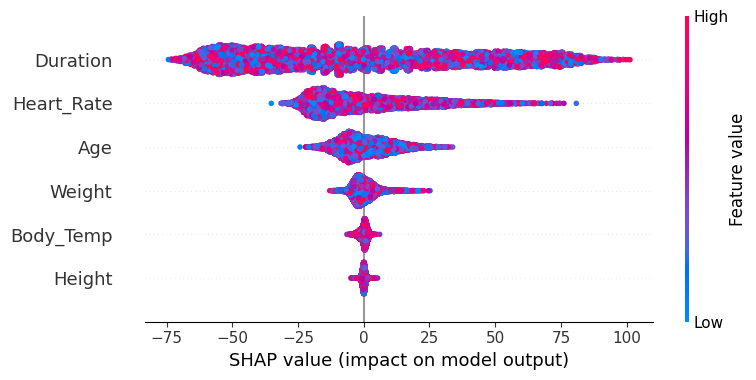

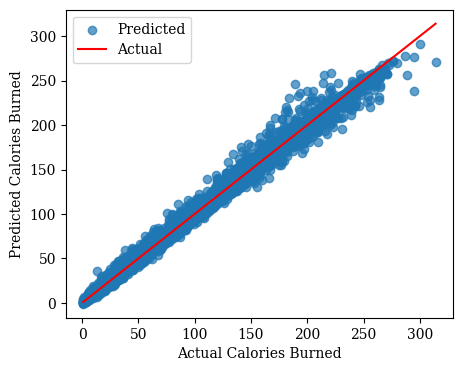

Average MAE: 2.022
Average MSE: 14.224
Average R^2: 0.9964
Average PSNR: 37.41 dB
Average SNR: 29.29 dB


In [5]:
def calculate_snr(y_true, y_pred):
    signal_power = np.mean(np.square(y_true))
    noise_power = np.mean(np.square(y_true - y_pred))
    return 10 * np.log10(signal_power / noise_power)

def calculate_psnr(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    if mse == 0:
        return float("inf")
    max_val = np.max(y_true)
    return 20 * np.log10(max_val / np.sqrt(mse))

# Open file to save results
file = open("new_data.csv", "a")

# Initialize the XGBoost Regressor model
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Initialize lists to store metrics for each fold
mae_list, mse_list, rmse_list, r2_list, psnr_list, snr_list = [], [], [], [], [], []
y_true_all, y_pred_all, shap_values_all = [], [], []

# Cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Store true and predicted values
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    psnr = calculate_psnr(y_test, y_pred)
    snr = calculate_snr(y_test, y_pred)

    # Write results to file
    file.write(f"{round(mae,3)},{round(mse,3)},{round(r2,4)},{round(psnr,2)},{round(snr,2)}\n")

    # Append metrics to lists
    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)
    psnr_list.append(psnr)
    snr_list.append(snr)

    # Print metrics for each fold
    print(f'Fold results:')
    print(f'MAE: {mae:.3f}, MSE: {mse:.3f}, R^2: {r2:.4f}, PSNR: {psnr:.2f} dB, SNR: {snr:.2f} dB')
    print('-' * 50)

    # SHAP Explainer for XGBoost
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test).values
    shap_values_all.append(shap_values)

# Concatenate all SHAP values
total_shap_values = np.vstack(shap_values_all)

# SHAP summary plot
shap.summary_plot(total_shap_values, X, feature_names=data.columns[1:7])

# Convert to numpy for regression plot
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

plt.rc('font', family='serif')

# Regression plot
plt.figure(figsize=(5, 4))
plt.scatter(y_true_all, y_pred_all, alpha=0.7, label='Predicted')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', label='Actual')
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.legend()
plt.show()

# Print average metrics
print(f'Average MAE: {np.mean(mae_list):.3f}')
print(f'Average MSE: {np.mean(mse_list):.3f}')
print(f'Average R^2: {np.mean(r2_list):.4f}')
print(f'Average PSNR: {np.mean(psnr_list):.2f} dB')
print(f'Average SNR: {np.mean(snr_list):.2f} dB')

file.close()
